# Classifier

### Import dataset

In [1]:
import pandas as pd

file_path = "../data/catering_reviews.csv"
data = pd.read_csv(file_path)

if data is not None:
    print("Processed Data:")
    print(data.head())
else:
    print("No data to process.")

Processed Data:
     author  rating                                               text  \
0   Estelle     5.0  Monsieur M a surpassé toutes nos attentes lors...   
1  Patricia     5.0  Nous recommandons vivement les services de Mon...   
2     Julie     4.8  Un grand merci à Camille et à toute l’équipe d...   
3  Amandine     5.0  L’équipe était très professionnel, souriante e...   
4  Mathilde     5.0  Accompagnement en amont, prestation le jour J,...   

         date sentiment        source                company_id company_name  
0  2024-04-11  positive  mariages.net  6852d3d474c91954046c1cdb   Monsieur M  
1  2025-05-25  positive  mariages.net  6852d3d474c91954046c1cdb   Monsieur M  
2  2024-12-10  positive  mariages.net  6852d3d474c91954046c1cdb   Monsieur M  
3  2024-11-09  positive  mariages.net  6852d3d474c91954046c1cdb   Monsieur M  
4  2025-02-02  positive  mariages.net  6852d3d474c91954046c1cdb   Monsieur M  


### Clean dataset

In [2]:
df = data[["text", "sentiment"]].dropna()

# Mapping label
label2id = {"negative": 0, "neutral": 1, "positive": 2}
id2label = {v: k for k, v in label2id.items()}

# Apply mapping
df["label"] = df["sentiment"].map(label2id)

# Supprimer NaN dans les lables
df = df.dropna(subset=["label"])

# Convert label to int64
df["label"] = df["label"].astype("int64")

print(df["label"].value_counts())
print(df.head())

label
2    4338
0      44
1      24
Name: count, dtype: int64
                                                text sentiment  label
0  Monsieur M a surpassé toutes nos attentes lors...  positive      2
1  Nous recommandons vivement les services de Mon...  positive      2
2  Un grand merci à Camille et à toute l’équipe d...  positive      2
3  L’équipe était très professionnel, souriante e...  positive      2
4  Accompagnement en amont, prestation le jour J,...  positive      2


### Over + Under sampling

In [3]:
# Less majority class
df_pos = df[df["label"] == 2].sample(n=100, random_state=42)  # réduit les positives
df_neg = df[df["label"] == 0]
df_neu = df[df["label"] == 1]

# More minority classes
df_neg_oversampled = pd.concat([df_neg] * 3, ignore_index=True)
df_neu_oversampled = pd.concat([df_neu] * 4, ignore_index=True)

# Final balanced dataset
df_balanced = pd.concat([df_pos, df_neg_oversampled, df_neu_oversampled], ignore_index=True)

print(df_balanced["label"].value_counts())

label
0    132
2    100
1     96
Name: count, dtype: int64


### Convert df to hugging face format

In [4]:
from datasets import Dataset

# On encode the DataFrame to a Hugging Face Dataset
dataset = Dataset.from_pandas(df_balanced[["text", "label"]])

# On split le hugging face dataset into train and test sets
tt_split = dataset.train_test_split(test_size=0.2, seed=42)

### Tokenizze avec CamemBERT

In [6]:
from transformers import CamembertTokenizer

tokenizer = CamembertTokenizer.from_pretrained("camembert-base")

def tokenize(data):
    return tokenizer(data["text"], truncation=True, padding="max_length", max_length=128)

tokenized_split = tt_split.map(tokenize, batched=True)

Map:   0%|          | 0/262 [00:00<?, ? examples/s]

Map:   0%|          | 0/66 [00:00<?, ? examples/s]

### Classifier

- I am using a pretrained CamemBERT model.
- The type of model is camembert-base.

In [7]:
from transformers import CamembertForSequenceClassification

model = CamembertForSequenceClassification.from_pretrained(
    "camembert-base",
    num_labels=3,
    id2label=id2label,
    label2id=label2id
)

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Create the trainer

- Here, I am building the trainer.
- I am using the `TrainingArguments` class to set the training parameters. This will be my base configuration. I will try to fine-tune it later.
- I am using the `Trainer` class to create the trainer.
- Then, I train.

In [9]:
from transformers import TrainingArguments, Trainer
import numpy as np

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    return {
        "accuracy": (preds == p.label_ids).mean(),
    }

training_args = TrainingArguments(
    output_dir="../models/camembert_sentiment",
    eval_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=20,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=50,
    weight_decay=0.01,
    #logging_dir="../logs",
    load_best_model_at_end=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_split["train"],
    eval_dataset=tokenized_split["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

/var/folders/pl/z799lglj00b41cclm26nwxmh0000gn/T/ipykernel_95164/980407266.py:24: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.017300,0.080466,0.984848
2,0.006600,0.094989,0.984848
3,0.002500,0.098637,0.984848
4,0.001500,0.109658,0.984848
5,0.001000,0.115962,0.984848
6,0.000800,0.111631,0.984848
7,0.000600,0.113529,0.984848
8,0.000500,0.113039,0.984848
9,0.000400,0.110619,0.984848
10,0.000400,0.111044,0.984848


/Users/joachimjasmin/miniconda3/envs/ai-wedder/lib/python3.13/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/joachimjasmin/miniconda3/envs/ai-wedder/lib/python3.13/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/joachimjasmin/miniconda3/envs/ai-wedder/lib/python3.13/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/joachimjasmin/miniconda3/envs/ai-wedder/lib/python3.13/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't

TrainOutput(global_step=660, training_loss=0.0017172312857865384, metrics={'train_runtime': 229.0162, 'train_samples_per_second': 22.88, 'train_steps_per_second': 2.882, 'total_flos': 344678577223680.0, 'train_loss': 0.0017172312857865384, 'epoch': 20.0})

### Vérification

In [10]:
preds_output = trainer.predict(tokenized_split["test"])

/Users/joachimjasmin/miniconda3/envs/ai-wedder/lib/python3.13/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


### Récupération des lables

In [11]:
import numpy as np

y_pred = np.argmax(preds_output.predictions, axis=1)

# True labels
y_true = preds_output.label_ids

### Confusion Matrix

<Figure size 600x600 with 0 Axes>

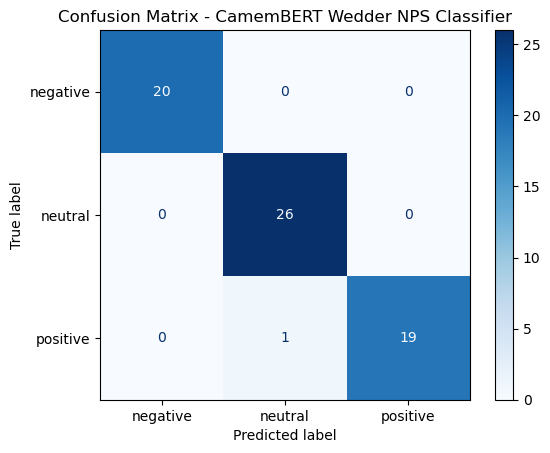

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

labels = ["negative", "neutral", "positive"]

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

plt.figure(figsize=(6, 6))
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix - CamemBERT Wedder NPS Classifier")
plt.show()

In [13]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=labels))

              precision    recall  f1-score   support

    negative       1.00      1.00      1.00        20
     neutral       0.96      1.00      0.98        26
    positive       1.00      0.95      0.97        20

    accuracy                           0.98        66
   macro avg       0.99      0.98      0.99        66
weighted avg       0.99      0.98      0.98        66



### Save model lacally (gitignored)

In [14]:
trainer.save_model("../models/camembert_wedder_nps_classifier")
tokenizer.save_pretrained("../models/camembert_wedder_nps_classifier")

('../models/camembert_wedder_nps_classifier/tokenizer_config.json',
 '../models/camembert_wedder_nps_classifier/special_tokens_map.json',
 '../models/camembert_wedder_nps_classifier/sentencepiece.bpe.model',
 '../models/camembert_wedder_nps_classifier/added_tokens.json')

### Save model to HF Hub

In [15]:
# Reload
model = CamembertForSequenceClassification.from_pretrained("../models/camembert_wedder_nps_classifier")
tokenizer = CamembertTokenizer.from_pretrained("../models/camembert_wedder_nps_classifier")

In [24]:
# Push to Hugging Face Hub
from dotenv import load_dotenv
import os

load_dotenv()
HF_TOKEN = os.getenv("HF_TOKEN")

model.push_to_hub("Jyokim/camembert-wedder-nps-classifier", use_auth_token=HF_TOKEN)
tokenizer.push_to_hub("Jyokim/camembert-wedder-nps-classifier", use_auth_token=HF_TOKEN)

model.safetensors:   0%|          | 0.00/443M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/811k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Jyokim/camembert-wedder-nps-classifier/commit/732338b48b4e208c2e539136eeb2db965732ce2e', commit_message='Upload tokenizer', commit_description='', oid='732338b48b4e208c2e539136eeb2db965732ce2e', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Jyokim/camembert-wedder-nps-classifier', endpoint='https://huggingface.co', repo_type='model', repo_id='Jyokim/camembert-wedder-nps-classifier'), pr_revision=None, pr_num=None)

### Try model

In [26]:
from transformers import pipeline

pipe = pipeline("text-classification", model="Jyokim/camembert-wedder-nps-classifier", tokenizer="Jyokim/camembert-wedder-nps-classifier")

print(pipe("Le repas était excellent mais le service très lent."))
print(pipe("J'ai tout adoré !"))
print(pipe("Je ne sais pas quoi en penser, c'était moyen."))
print(pipe("C'était vraiment mauvais, je ne reviendrai pas."))
print(pipe("Le repas était correct, sans plus."))
print(pipe("Le dessert était délicieux, mais le plat principal était décevant."))
print(pipe("Le service était impeccable, mais la nourriture était fade."))
print(pipe("Une expérience culinaire inoubliable, je recommande vivement !"))
print(pipe("Le traiteur a fait un travail pas mal, mais il y a de la place pour l'amélioration."))
print(pipe("Le repas était froid et le service désagréable."))
print(pipe("C'était un repas ordinaire, rien de spécial."))
print(pipe("Le repas était exceptionnel, un vrai régal pour les papilles !"))
print(pipe("Le service était rapide et efficace, mais la nourriture manquait de saveur."))

tokenizer_config.json:   0%|          | 0.00/1.81k [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/811k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/22.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

Device set to use mps:0


[{'label': 'negative', 'score': 0.9616328477859497}]
[{'label': 'positive', 'score': 0.9892773628234863}]
[{'label': 'neutral', 'score': 0.9799679517745972}]
[{'label': 'negative', 'score': 0.9840548634529114}]
[{'label': 'neutral', 'score': 0.984420120716095}]
[{'label': 'negative', 'score': 0.9931852221488953}]
[{'label': 'negative', 'score': 0.9836894869804382}]
[{'label': 'positive', 'score': 0.9908341765403748}]
[{'label': 'neutral', 'score': 0.9882218241691589}]
[{'label': 'negative', 'score': 0.9916757345199585}]
[{'label': 'neutral', 'score': 0.9846189618110657}]
[{'label': 'positive', 'score': 0.99041348695755}]
[{'label': 'neutral', 'score': 0.9136963486671448}]
